In [1]:
from typing import List, Dict, Tuple, Optional, Callable, Any
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

## Test-Functions

In [127]:
from src.algorithms.test_functions import mk_quad, mk_gauss, rosenbrock, rosenbrock_grad

# Quadratic kernel functions
def test_quad():
    epsilon = 0.5
    ndim = 2
    f, f_prime = mk_quad(epsilon, ndim)

    x = torch.tensor([1.0, 2.0], requires_grad=True)

    # Test the function
    y = f(x)
    y.backward()
    y_manual = f_prime(x)

    assert torch.allclose(x.grad, y_manual, atol=1e-6)

# Non-convex Gaussian kernel functions
def test_gaussian():
    epsilon = 0.5
    ndim = 2
    f, f_prime = mk_gauss(epsilon, ndim)

    x = torch.tensor([1.0, 2.0], requires_grad=True)

    # Test the function
    y = f(x)
    y.backward()
    y_manual = f_prime(x)

    assert torch.allclose(x.grad, y_manual, atol=1e-6)

# Ill-condition problem: Rosenbrock function (flat region)
def test_rosenbrock():
    x = torch.tensor([1.0, 2.0], requires_grad=True)

    # Test the function
    y = rosenbrock(x)
    y.backward()
    y_manual = rosenbrock_grad(x)

    assert torch.allclose(x.grad, y_manual, atol=1e-6)

# Run the tests
test_quad()
test_gaussian()
test_rosenbrock()

print("All tests passed!")


All tests passed!


## Adam Optimizer

In [4]:
from src.algorithms.adam import AdamOptimizer

torch.manual_seed(0)
initial_guess = torch.rand(2)
objective_function, gradient_function = mk_quad(0.98, ndim=2)
adam_optimizer = AdamOptimizer(0.1)
optimized_theta, min_value, min_gradient = adam_optimizer.minimize(
    initial_guess, objective_function, gradient_function
)
print(initial_guess)
print("Optimized Theta:", optimized_theta)
print("Minimum Value:", min_value)
print("Gradient at Minimum:", min_gradient)
print("All x_k:", adam_optimizer.all_x_k)
print("All f_k:", adam_optimizer.all_f_k)


tensor([0.4963, 0.7682])
Optimized Theta: tensor([1.5886e-07, 4.3826e-07])
Minimum Value: tensor(1.0485e-13)
Gradient at Minimum: tensor([1.5886e-07, 4.2090e-07])
All x_k: [array([0.4962566, 0.7682218], dtype=float32), array([0.3962573, 0.6682225], dtype=float32), array([0.29746073, 0.56882703], dtype=float32), array([0.2011964, 0.4705892], dtype=float32), array([0.10936423, 0.3742114 ], dtype=float32), array([0.0245062 , 0.28056502], dtype=float32), array([-0.05032725,  0.1907078 ], dtype=float32), array([-0.11207394,  0.10587852], dtype=float32), array([-0.1584425 ,  0.02745324], dtype=float32), array([-0.18854852, -0.04314332], dtype=float32), array([-0.20299453, -0.10457532], dtype=float32), array([-0.20345107, -0.15575592], dtype=float32), array([-0.19212097, -0.19598895], dtype=float32), array([-0.17135617, -0.22504771], dtype=float32), array([-0.1434709 , -0.24317181], dtype=float32), array([-0.11068514, -0.25099695], dtype=float32), array([-0.07512569, -0.24945076], dtype=float

## Wrapper for Optimizers

In [11]:
def simple_optimizer(optimizer_cls, x_init, loss_fn, optim_kwargs={}, max_iter=100, grad_threshold=1e-6):
    x_init = torch.tensor(x_init, dtype=torch.float64, requires_grad=True)
    x = x_init.clone().detach().requires_grad_(True)
    optimizer = optimizer_cls([x], **optim_kwargs)

    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = loss_fn(x)
        loss.backward()
        optimizer.step()

        grad = x.grad.detach().numpy()
        if np.min(np.abs(grad)) < grad_threshold:
            break

    optimized_x = x.detach().numpy()
    final_loss = loss_fn(x).detach().numpy()
    
    return optimized_x, final_loss

def test_simple_optimizer():
    def quadratic_loss(x):
        return torch.sum(x**2)

    optimizer_cls = torch.optim.Adam
    x_init = np.array([1.0, 2.0])
    optim_kwargs = {"lr": 5}
    max_iter = 1000
    grad_threshold = 1e-6

    optimized_x, final_loss = simple_optimizer(
        optimizer_cls, x_init, quadratic_loss, optim_kwargs, max_iter, grad_threshold
    )

    print("Optimized x:", optimized_x)
    print("Final Loss:", final_loss)

test_simple_optimizer()

Optimized x: [-3.06631428e-05 -3.77415612e-05]
Final Loss: 2.3646537619739014e-09


In [126]:
from typing import Callable, Dict, Tuple

def optimize_with_one_optimizer(
    optimizer_cls,
    x_init: np.ndarray,
    loss_fn: Callable,
    loss_grad: Optional[Callable] = None, # only for AdamOptimizer
    optim_kwargs: Dict[str, Any] = None,
    max_iter: int = 100,
    
    tol_grad: float = 1e-6
) -> Tuple[np.ndarray, np.ndarray]:
    if optimizer_cls == AdamOptimizer:
        if loss_grad is None:
            raise ValueError("AdamOptimizer require `loss_grad`.")
        adam_optimizer = AdamOptimizer(**optim_kwargs)
        adam_optimizer.minimize(x_init, f=loss_fn, f_grad=loss_grad, max_iter=max_iter)

        return adam_optimizer.all_x_k, adam_optimizer.all_f_k 
    
    x = torch.tensor(x_init, dtype=torch.float64, requires_grad=True)
    optimizer = optimizer_cls([x], **optim_kwargs)
    all_x_k, all_f_k = [x_init], [loss_fn(x).item()]

    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = loss_fn(x)
        loss.backward()

        with torch.no_grad():
            optimizer.step()
            x_k_np = x.detach().numpy().copy()
            all_x_k.append(x_k_np)
            all_f_k.append(loss.item())

            if np.min(np.abs(x.grad.detach().numpy().copy())) < tol_grad:
                break

    return np.array(all_x_k), np.array(all_f_k)


np.random.seed(42)
x0 = np.array([1.6, 1.1])
x_init = np.random.rand(2)
print(x_init)

# Example usage:
solutions, images = optimize_with_one_optimizer(
    optimizer_cls=optim.SGD,
    x_init=x_init, 
    loss_fn=rosenbrock,
    optim_kwargs={"lr": 1e-4, "nesterov": True, "momentum": 0.99, "dampening": 0.},
    max_iter=1000
)

solutions, images = optimize_with_one_optimizer(
    optimizer_cls=AdamOptimizer,
    x_init=x_init,
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optim_kwargs={"lr": 1e-2},
    max_iter=1000
)

print("Final Solution:", solutions, len(solutions))
print("Final Value:", images[-1])


[0.37454012 0.95071431]
Final Solution: [array([0.37454012, 0.95071431]), array([0.38454005, 0.94071437]), array([0.39454102, 0.9307208 ]), array([0.40454336, 0.92073798]), array([0.41454681, 0.9107708 ]), array([0.42455091, 0.90082413]), array([0.43455476, 0.89090313]), array([0.44455698, 0.88101329]), array([0.45455585, 0.87116023]), array([0.46454919, 0.86134982]), array([0.4745344 , 0.85158815]), array([0.48450839, 0.84188158]), array([0.49446761, 0.83223666]), array([0.50440808, 0.82266017]), array([0.51432526, 0.81315912]), array([0.52421416, 0.80374071]), array([0.53406924, 0.79441238]), array([0.54388448, 0.78518174]), array([0.55365327, 0.77605662]), array([0.56336847, 0.76704503]), array([0.57302241, 0.7581551 ]), array([0.58260685, 0.74939515]), array([0.592113  , 0.74077362]), array([0.60153148, 0.73229904]), array([0.61085239, 0.72398004]), array([0.62006527, 0.71582529]), array([0.62915912, 0.70784349]), array([0.63812244, 0.70004329]), array([0.64694326, 0.69243331]), ar

In [120]:
def optimize_with_multiple_optimizers(x_init, loss_fn, loss_grad, optimizers_config, max_iter=1000, tol_grad=1e-6):
    solutions, values = {}, {}

    for optim_name, (optim_cls, optim_kwargs) in optimizers_config.items():
        if optim_cls == AdamOptimizer:
            adam_optim = optim_cls(**optim_kwargs)
            adam_optim.minimize(theta_init=x_init, f=loss_fn, f_grad=loss_grad, f_grad_args=(), max_iter=max_iter)
            solutions[optim_name] = np.array(adam_optim.all_x_k)
            values[optim_name] = np.array(adam_optim.all_f_k)
        else:
            s, v = optimize_with_one_optimizer(optim_cls, x_init, loss_fn, optim_kwargs, max_iter, tol_grad)
            solutions[optim_name] = s
            values[optim_name] = v

    return solutions, values

# Example usage:
optimizers_config = {
    "Adam (Torch)": (optim.Adam, {"lr": 1e-1}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-1}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}),
    "Adam (Local)": (AdamOptimizer, {"lr": 1e-1}),
}

solutions, values = optimize_with_multiple_optimizers(
    x_init=x_init,
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optimizers_config=optimizers_config,
    max_iter=1000,
    tol_grad=1e-6
)
print(solutions)
for optimizer, solution in solutions.items():
    print(f"{optimizer} - Final Solution: {solution[-1]}, Final Value: {values[optimizer][-1]}")

{'Adam (Torch)': array([[0.37454012, 0.95071431],
       [0.47454012, 0.85071431],
       [0.57447111, 0.75219916],
       ...,
       [0.99058624, 0.98122496],
       [0.99063893, 0.98132955],
       [0.99069136, 0.98143363]]), 'Adagrad': array([[0.37454012, 0.95071431],
       [0.47454012, 0.85071431],
       [0.54440558, 0.78961351],
       ...,
       [0.82537401, 0.6804679 ],
       [0.82541022, 0.68052785],
       [0.82544642, 0.68058779]]), 'RMSprop': array([[ 0.37454012,  0.95071431],
       [ 1.37454012, -0.04928569],
       [ 0.38102316,  0.87402738],
       ...,
       [ 0.34584559,  0.03411241],
       [ 0.24420455,  0.14300293],
       [ 0.33755656,  0.03689239]]), 'SGD-Nesterov': array([[0.37454012, 0.95071431],
       [0.6076073 , 0.64274938],
       [0.83478485, 0.40750523],
       ...,
       [0.99529428, 0.99059182],
       [0.99531388, 0.99063092],
       [0.99533341, 0.99066986]]), 'Adam (Local)': array([[0.37454012, 0.95071431],
       [0.47453945, 0.85071497],
   

In [89]:
from numpy.linalg import norm

def tune_learning_rate(x_star, params_grid, loss_fn, loss_grad, max_iter, optimizers_config: dict):
    lrs = params_grid["lr"]
    all_diffs = {opt_name: [np.inf] for opt_name, _ in optimizers_config.items()}

    for lr in lrs:
        configs = {optim_name: (optim_cls, {**config, "lr": lr})
                   for optim_name, (optim_cls, config) in optimizers_config.items()}
        solutions, _ = optimize_with_multiple_optimizers(
            x_init=x_init,
            loss_fn=loss_fn,
            loss_grad=loss_grad,
            optimizers_config=configs,
            max_iter=max_iter
        )
        all_diffs.update({opt_name: lst + [norm(solution - x_star)] 
                          for lst in all_diffs.values() 
                          for opt_name, solution in solutions.items()})

    best_lrs = {opt_name: lrs[np.argmin(diffs) - 1] 
                for opt_name, diffs in all_diffs.items()}

    return best_lrs

# Example usage:
x_star = np.array([1.0, 1.0])
params_grid = {"lr": 10.0**np.arange(3, -4, -1)}
max_iter = 1000

quadratic, quadratic_grad = mk_quad(0.5)
best_lrs = tune_learning_rate(
    x_star=x_star,
    params_grid=params_grid,
    loss_fn=quadratic,
    loss_grad=quadratic_grad,
    max_iter=max_iter,
    optimizers_config=optimizers_config
)

print("Best Learning Rates:")
for optimizer, lr in best_lrs.items():
    print(f"{optimizer}: {lr}")


Best Learning Rates:
Adam (Torch): 1.0
Adagrad: 1.0
RMSprop: 1.0
SGD-Nesterov: 1.0
Adam (Local): 1.0


[0.37454012 0.95071431]


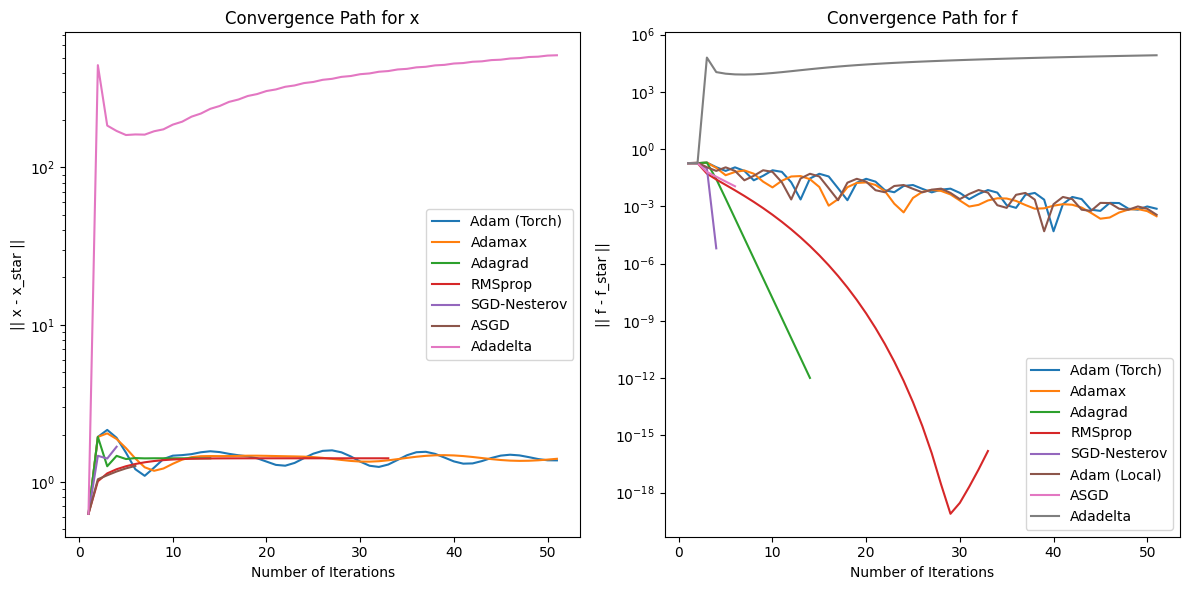

In [119]:
from scipy.stats import zscore
def plot_convergence(solutions, values, x_star, f_star, zscore_threshold=10):
    plt.figure(figsize=(12, 6))

    # Plotting || x - x_star ||
    plt.subplot(1, 2, 1)
    for optim_name in solutions.keys():
        if "local" in optim_name.lower():
            continue
        x_diff = np.linalg.norm(solutions[optim_name] - x_star, axis=1)
        
        # Remove outliers based on z-scores
        z_scores = zscore(x_diff)
        valid_indices = np.abs(z_scores) < zscore_threshold
        plt.plot(np.arange(1, len(x_diff) + 1)[valid_indices], x_diff[valid_indices], label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('|| x - x_star ||')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for x')

    # Plotting || f - f_star ||
    plt.subplot(1, 2, 2)
    for optim_name in solutions.keys():
        f_diff = np.abs(values[optim_name] - f_star)
        
        # Remove outliers based on z-scores
        z_scores = zscore(f_diff)
        valid_indices = np.abs(z_scores) < zscore_threshold
        plt.plot(np.arange(1, len(f_diff) + 1)[valid_indices], f_diff[valid_indices], label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('|| f - f_star ||')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for f')

    plt.tight_layout()  # Ensure proper layout
    plt.show()



print(x_init)
optimizers_config = {
    "Adam (Torch)": (optim.Adam, {"lr": 1e0}),
    "Adamax": (optim.Adamax, {"lr": 1e0}),
    "Adagrad": (optim.Adagrad, {"lr": 1e0}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "alpha": 0.9}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e0, "nesterov": True, "momentum": 0.99, "dampening": 0}),
    "Adam (Local)": (AdamOptimizer, {"lr": 1e0}),
    "ASGD": (optim.ASGD, {"lr": 1e0}),
    "Adadelta": (optim.Adadelta, {"lr": 1e5})
}
quadratic, quadratic_grad = mk_quad(0.5)
solutions, values = optimize_with_multiple_optimizers(
    x_init=x_init,
    loss_fn=quadratic,
    loss_grad=quadratic_grad,
    optimizers_config=optimizers_config,
    max_iter=50,
    tol_grad=1e-15
)
x_star = np.array([1, 1])
f_star = 0.0
plot_convergence(solutions, values, x_star, f_star)

## Comparison

### Quadratic Function (good conditioning)

In [214]:
quad_1, quad_1_prime = mk_quad(epsilon=0.98)
quad_1_torch, _ = mk_quad(epsilon=0.98)
best_params = tune_params(x_init=x_init, x_star=[0, 0], f_star=0.0, loss_fn=quad_1_torch)
best_params

{'Adam (Torch)': {'lr': 0.1, 'beta1': 0.8844444444444445},
 'SGD-Nesterov': {'lr': 10.0, 'momentum': 0.1},
 'RMSprop': {'lr': 10.0, 'alpha': 0.99},
 'Adagrad': {'lr': 10.0}}

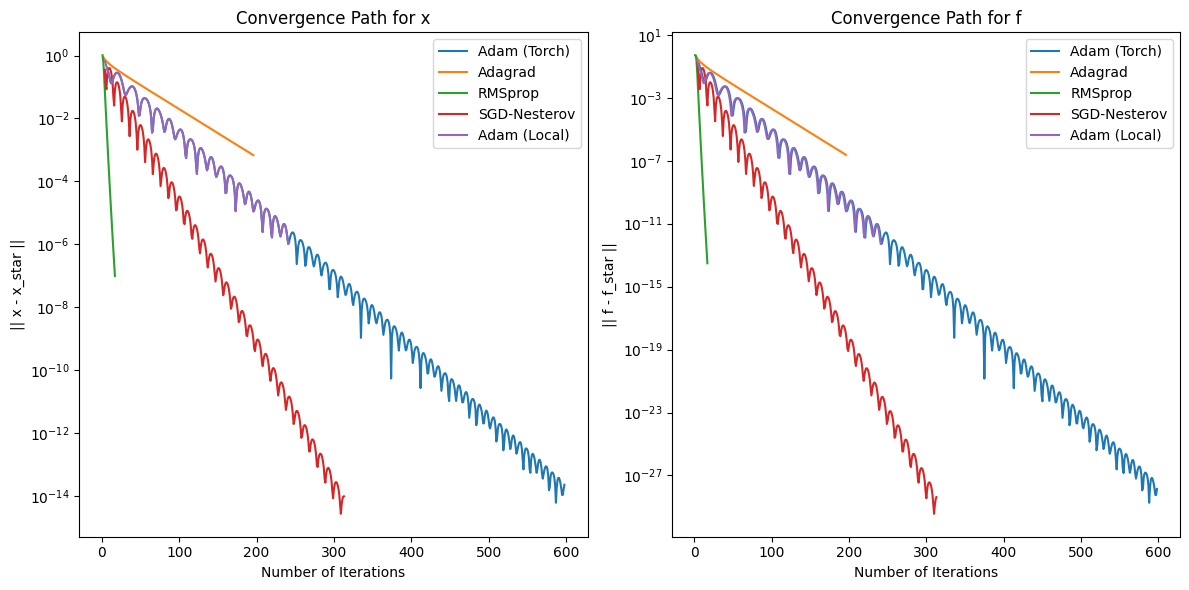

In [234]:
sols_quad1, vals_quad1 = optimize_function(
    x_init=x_init,
    loss_fn=quad_1_torch, f=quad_1, f_grad=quad_1_prime,
    adam_local_kw={"lr": 1e-1, "beta1": 0.9},
    adam_torch_kw={"lr": 1e-1},
    adagrad_kw={"lr": 1e-1},
    rmsprop_kw={"lr": 1e-1, "alpha": 0.99},
    sgd_nesterov_kw={"lr": 1e-1, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

x_star, f_star = np.array([0, 0]), 0.0
plot_convergence(sols_quad1, vals_quad1, x_star, f_star)

### Quadratic Function (bad conditioning)

In [238]:
quad_2, quad_2_prime = mk_quad(epsilon=0.98)
quad_2_torch, _ = mk_quad_torch(epsilon=0.98)
best_params = tune_params_wrap(x_init=x_init, x_star=[0, 0], f_star=0.0, loss_fn=quad_2_torch)
best_params

{'Adam (Torch)': {'lr': 0.1, 'beta1': 0.8844444444444445},
 'SGD-Nesterov': {'lr': 10.0, 'momentum': 0.1},
 'RMSprop': {'lr': 10.0, 'alpha': 0.99},
 'Adagrad': {'lr': 10.0}}

In [236]:
quad_2, quad_2_prime = mk_quad(epsilon=0.02)
quad_2_torch, _ = mk_quad_torch(epsilon=0.02)
sols_quad2, vals_quad2 = optimize_function(
    x_init=x_init,
    loss_fn=quad_2_torch, f=quad_2, f_grad=quad_2_prime,
    adam_local_kw={"lr": 1e-3},
    adam_torch_kw={"lr": 1e-3},
    adagrad_kw={"lr": 1e-3},
    rmsprop_kw={"lr": 1e-3},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

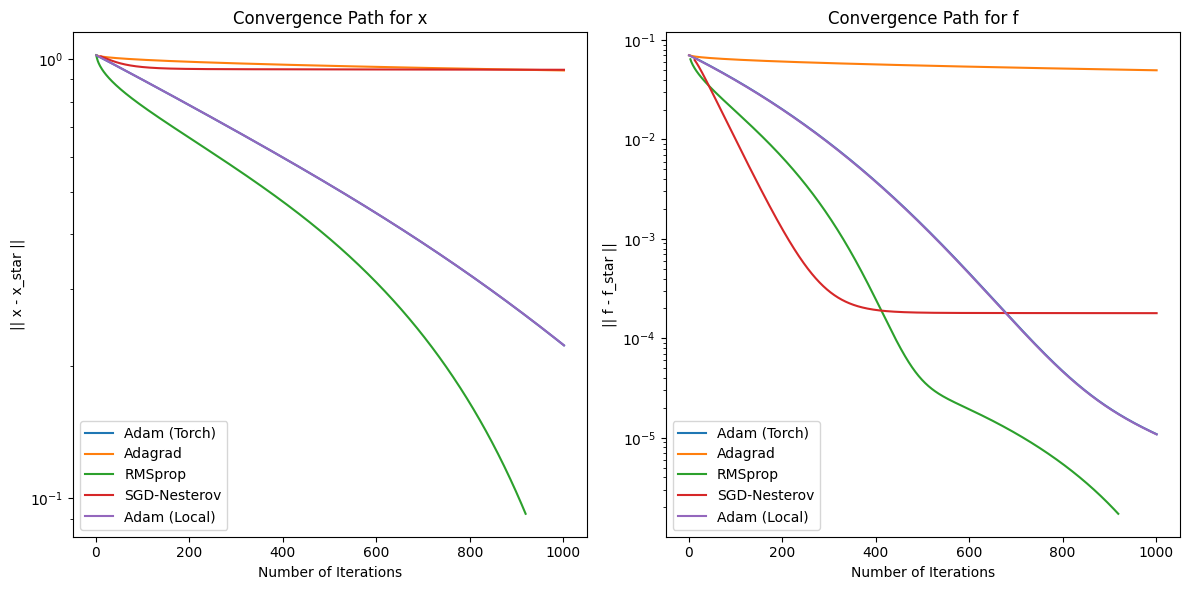

In [237]:
x_star, f_star = np.array([0, 0]), 0.0
plot_convergence(sols_quad2, vals_quad2, x_star, f_star)

### Non-Convex Gaussian Kernel 

In [ ]:
gauss, gauss_prime = mk_gauss(epsilon=1.4)
gauss_torch, _ = mk_quad_torch(epsilon=1.4)
sols_gauss, vals_gauss = optimize_function(
    loss_fn=gauss_torch, f=gauss, f_grad=gauss_prime,
    adam_local_kw={"lr": 1e-3},
    adam_torch_kw={"lr": 1e-3},
    adagrad_kw={"lr": 1e-3},
    rmsprop_kw={"lr": 1e-3},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

### Rosenbrock Function (flat region)

In [194]:
sols_rosen, vals_rosen = optimize_function(
    x_init=x_init,
    loss_fn=rosenbrock_torch, f=rosen, f_grad=rosen_der,
    adam_local_kw={"lr": 1., "beta1": 0.9, "beta2": 0.999},
    adam_torch_kw={"lr": 1.},
    adagrad_kw={"lr": 1.},
    rmsprop_kw={"lr": 1e-2, "alpha": 0.9},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.95, "dampening": 0}
)


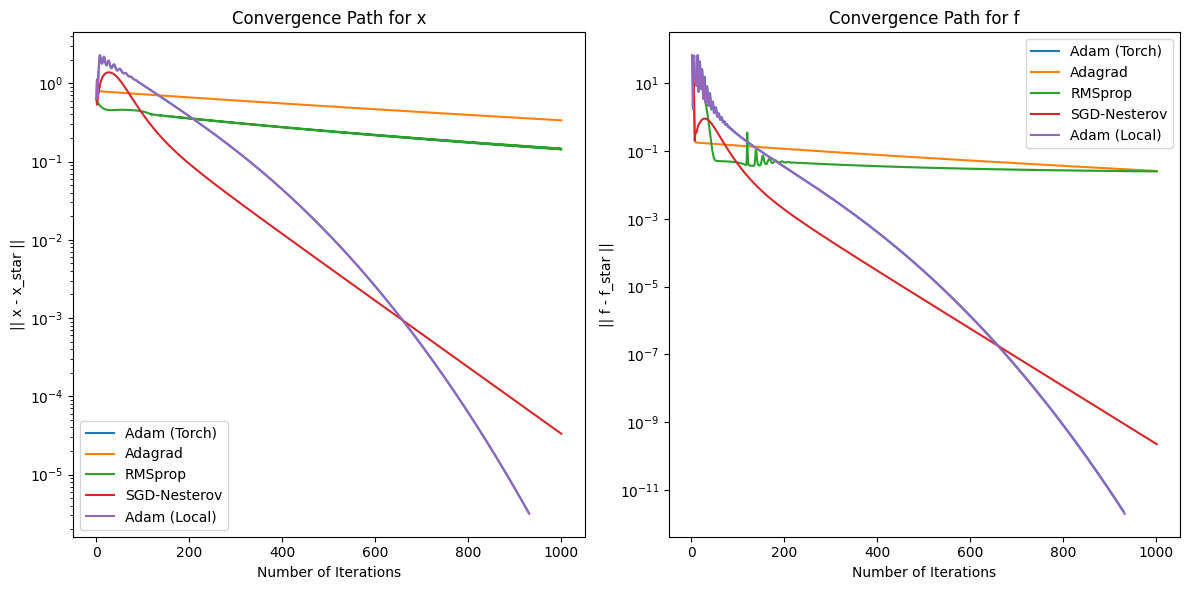

In [195]:
x_star, f_star = np.array([1, 1]), 0.0
plot_convergence(sols_rosen, vals_rosen, x_star, f_star)

### Eggholder (local minima)

In [13]:
sols_eggholder, vals_eggholder = optimize_with_multiple_optimizers(
    loss_fn=eggcrate, loss_grad=eggcrate_grad,
    adam_local_kw={"lr": 1e-3},
    adam_torch_kw={"lr": 1e-3},
    adagrad_kw={"lr": 1e-3},
    rmsprop_kw={"lr": 1e-3},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

In [ ]:
x_star, f_star = np.array([1, 1]), 0.0
plot_convergence(sols_eggholder, vals_eggholder, x_star, f_star)